In [4]:
!pip install tensorflow opencv-python matplotlib scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(image_dir, annotation_dir, annotation_format='yolo'):
    images = []
    annotations = []
    for filename in os.listdir(image_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(image_dir, filename)
            annotation_path = os.path.join(annotation_dir, filename.replace(os.path.splitext(filename)[1], '.txt'))
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)

            if os.path.exists(annotation_path):
              if annotation_format == 'yolo':
                with open(annotation_path, 'r') as f:
                  annotation_lines = f.readlines()
                  annotation = []
                  for line in annotation_lines:
                    parts = line.strip().split(' ')
                    annotation.append([float(part) for part in parts])
                annotations.append(annotation)
              else:
                #Add other annotation parsers here.
                pass
            else:
              annotations.append([])

    return np.array(images), annotations

images, annotations = load_data('/content/drive/MyDrive/ball_detection_dataset/train/images', '/content/drive/MyDrive/ball_detection_dataset/train/annotations')
x_train, x_test, y_train, y_test = train_test_split(images, annotations, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model

#Example of a simpler model, that will only regress the bounding box coordinates.
input_shape = x_train[0].shape
input_layer = Input(shape=input_shape)
base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_layer)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(4)(x) #4 outputs for x,y,width,height.

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='mse')

model.fit(x_train, np.array([np.mean(annotation, axis=0)[1:] if annotation else [0,0,0,0] for annotation in y_train]), validation_data=(x_val, np.array([np.mean(annotation, axis=0)[1:] if annotation else [0,0,0,0] for annotation in y_val])), epochs=10)

<ipython-input-14-112e9579138d>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_layer)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 640, 640, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 65s 65s/step - loss: 0.2913 - val_loss: 0.4936
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 2.9522 - val_loss: 0.4025
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 0.4046 - val_loss: 0.3347
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.2246 - val_loss: 0.3494
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.0797 - val_loss: 0.3722
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 0.0377 - val_loss: 0.3344
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 0.0155 - val_loss: 0.2898
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 0.0086 - val_loss: 0.2626
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.0069 - val_loss: 0.2346
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - loss: 0.0054 - val_loss: 0.2317


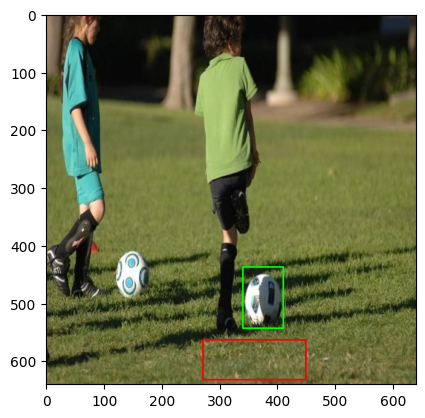

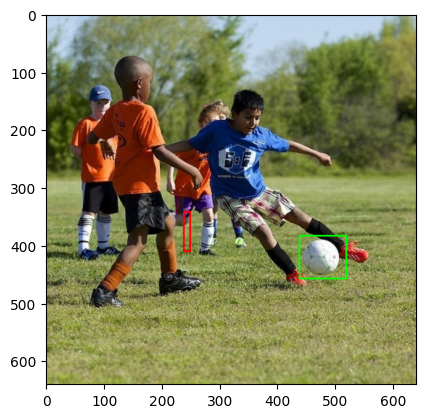

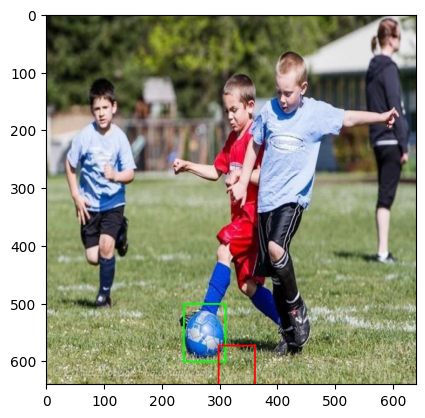

IoU for the first test image: -0.0


In [16]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def display_results(images, predictions, true_annotations):
  for i in range(min(5, len(images))):
    image = images[i].copy()
    pred = predictions[i]
    true_annotation = true_annotations[i]

    if len(true_annotation) > 0:
      true_x, true_y, true_w, true_h = true_annotation[0][1:]
      h, w, _ = image.shape
      true_x_min = int((true_x - true_w / 2) * w)
      true_y_min = int((true_y - true_h / 2) * h)
      true_x_max = int((true_x + true_w / 2) * w)
      true_y_max = int((true_y + true_h / 2) * h)
      cv2.rectangle(image, (true_x_min, true_y_min), (true_x_max, true_y_max), (0, 255, 0), 2)

    pred_x, pred_y, pred_w, pred_h = pred
    h, w, _ = image.shape
    pred_x_min = int((pred_x - pred_w / 2) * w)
    pred_y_min = int((pred_y - pred_h / 2) * h)
    pred_x_max = int((pred_x + pred_w / 2) * w)
    pred_y_max = int((pred_y + pred_h / 2) * h)
    cv2.rectangle(image, (pred_x_min, pred_y_min), (pred_x_max, pred_y_max), (255, 0, 0), 2)

    plt.imshow(image)
    plt.show()

display_results(x_test, predictions, y_test)

# Example of a simple IoU calculation. This is a very basic example and a more robust IOU and mAP calculation would be needed for a real model.
def calculate_iou(box1, box2):
    """Calculates the Intersection over Union (IoU) of two bounding boxes.

    Args:
        box1: A list or tuple representing the first bounding box [x_min, y_min, x_max, y_max].
        box2: A list or tuple representing the second bounding box [x_min, y_min, x_max, y_max].

    Returns:
        The IoU of the two bounding boxes.
    """

    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # Calculate the coordinates of the intersection rectangle
    x_intersection_min = max(x1_min, x2_min)
    y_intersection_min = max(y1_min, y2_min)
    x_intersection_max = min(x1_max, x2_max)
    y_intersection_max = min(y1_max, y2_max)

    # Calculate the area of intersection rectangle
    intersection_width = max(0, x_intersection_max - x_intersection_min)
    intersection_height = max(0, y_intersection_max - y_intersection_min)
    intersection_area = intersection_width * intersection_height

    # Calculate the area of both bounding boxes
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    # Calculate the IoU
    iou = intersection_area / float(box1_area + box2_area - intersection_area)

    return iou

#Example of calculating IOU for the first test image.
if len(y_test[0]) > 0:
  true_x, true_y, true_w, true_h = y_test[0][0][1:]
  h,w,_ = x_test[0].shape
  true_x_min = int((true_x - true_w / 2) * w)
  true_y_min = int((true_y - true_h / 2) * h)
  true_x_max = int((true_x + true_w / 2) * w)
  true_y_max = int((true_y + true_h / 2) * h)
  true_box = [true_x_min, true_y_min, true_x_max, true_y_max]

  pred_x, pred_y, pred_w, pred_h = predictions[0]
  pred_x_min = int((pred_x - pred_w / 2) * w)
  pred_y_min = int((pred_y - pred_h / 2) * h)
  pred_x_max = int((pred_x + pred_w / 2) * w)
  pred_y_max = int((pred_y + pred_h / 2) * h)
  pred_box = [pred_x_min, pred_y_min, pred_x_max, pred_y_max]

  iou = calculate_iou(true_box, pred_box)
  print(f"IoU for the first test image: {iou}")
else:
  print("No ground truth annotation for the first test image.")